In [1]:
from sklearn.datasets import fetch_20newsgroups # import the dataset
from pprint import pprint
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import tensorflow_datasets as tfds
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.models import Model
from ktrain import text
import ktrain
from tensorflow.keras import layers


In [2]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 107kB/s 
     |████████████████████████████████| 6.8MB 39.7MB/s 
     |████████████████████████████████| 983kB 41.8MB/s 
     |████████████████████████████████| 266kB 56.6MB/s 
     |████████████████████████████████| 1.9MB 41.8MB/s 
     |████████████████████████████████| 1.2MB 39.6MB/s 
     |████████████████████████████████| 471kB 36.7MB/s 
     |████████████████████████████████| 901kB 44.1MB/s 
     |████████████████████████████████| 3.3MB 39.0MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.3-cp37-none-any.whl size=25282390 sha256=3323ab2ca81e9b1687852c858e98a3093fbd640f92c79fbcd015c23bfd3a798c
  Stored in directory: /root/.cache/pip/wheels/16/05/be/d6e659b3349016b1059e19fa028f165af4eeae2c196f329112
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=11b6eed3492b464ad20056a0b222cc26aff7311e49d5246607dea42adf2ac5a3
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7d

# Reading the dataset 
#### take only four category from the dataset because (run time problem)

In [2]:
# take the train subset and test subset

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]
data_train = fetch_20newsgroups(subset='train',
                                categories=categories,
                                shuffle = True,
                                random_state = 7)

data_test = fetch_20newsgroups(subset='test',
                                shuffle = True,
                                categories=categories,
                                random_state = 7)

In [ ]:
pprint(list(data_train.target_names))

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [ ]:
# get the labels of x_test and x_train 
X_train,y_train,X_test,y_test =data_train.data,data_train.target,data_test.data, data_test.target

In [ ]:
print(f"Num. of training samples is {len(y_train)}")
print(f"Num. of test samples is {len(y_test)}")

Num. of training samples is 2034
Num. of test samples is 1353


# SVM Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Text Preprocessing 

1-Term Frequency – Inverse Document Frequency
Term Frequency: Number of time a word appears in a text document.
Inverse Document Frequency: Measure the word is a rare word or common word in a document.

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

max_df : Ignore the term that has a document frequency higher than a threshold.
min_df : Ignore the term that has a document frequency lower than a threshold.
stop_words : Remove the defined words from resulting vocabulary.
use_idf : boolean (default=True). Enable inverse-document-frequency reweighting.

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train.toarray(), y_train)

SVC()

In [ ]:
svm_pred = svm_clf.predict(X_train.toarray())
train_score = accuracy_score(y_train, svm_pred) * 100
print(f"Train accuracy score: {train_score:.2f}%")

svm_pred = svm_clf.predict(X_test.toarray())
test_score = accuracy_score(y_test, svm_pred) * 100
print(f"Test accuracy score: {test_score:.2f}%")

Train accuracy score: 99.95%
Test accuracy score: 88.62%


#### Confusion Matrix

In [ ]:
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

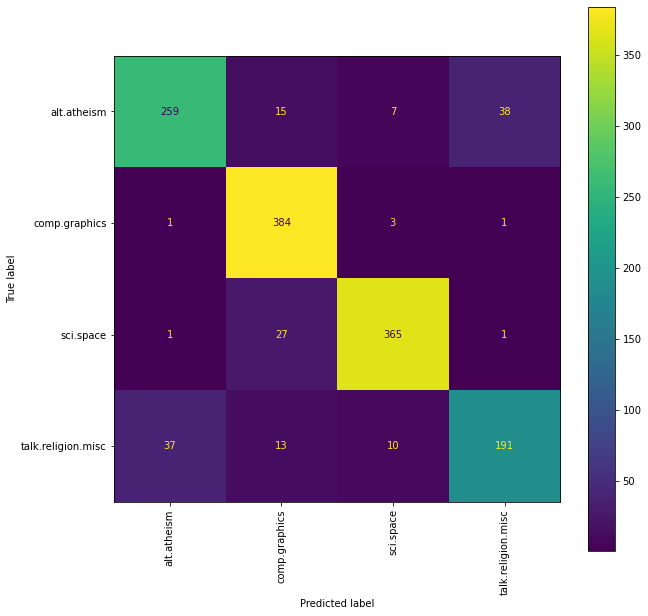

In [ ]:
cm = confusion_matrix(y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_train.target_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

#  CNN Model 


## Vetoriztion Step 
convert each word to vector using tensorflow_datasets

In [ ]:
print(3)
import tensorflow_datasets as tfds
vocab_fname='vocab_file'
print(2)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X_train, target_vocab_size=2**18)
print(1)
train_inputs = [tokenizer.encode(text) for text in X_train]
test_inputs = [tokenizer.encode(text) for text in X_test]
tokenizer.save_to_file(vocab_fname)


3
2
1


#### next run time load directly the vocab file 

In [ ]:
#vocab_fname='/content/vocab_file.subwords/'

In [ ]:
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file(vocab_fname)
#train_inputs = [tokenizer.encode(text) for text in X_train]
#test_inputs = [tokenizer.encode(text) for text in X_test]

In [ ]:
print(train_inputs[0]==train_inputs[1])

False


Padding is needed due to invarient of inputs data 

In [ ]:
import  tensorflow as tf
MAX_LEN = max([len(sentence) for sentence in train_inputs])
print(MAX_LEN)
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs,
                                                             value=0,
                                                             padding="post",
                                                             maxlen=MAX_LEN)

test_inputs = tf.keras.preprocessing.sequence.pad_sequences(test_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


14220


### Next Build the CNN architecture model 

In [ ]:
print(train_inputs.shape)

(2034, 14220)


In [ ]:
vocab_size = tokenizer.vocab_size

In [ ]:
class CNN_model(tf.keras.Model):
    def __init__(self, vocab_size,training=False, name="cnn_model"):
        super(CNN_model, self).__init__(name=name)
        self.embedding_vector = layers.Embedding(vocab_size, 128)
        self.first_conv_layer = layers.Conv1D(filters=50, kernel_size=2, padding="valid", activation="relu")
        self.second_conv_layer = layers.Conv1D(filters=50, kernel_size=3, padding="valid", activation="relu")
        self.third_conv_layer = layers.Conv1D(filters=50, kernel_size=4, padding="valid", activation="relu")
        self.max_pooling_layer = layers.GlobalMaxPool1D()                                
        self.dense_1 = layers.Dense(units=512, activation="relu")
        self.dropout = layers.Dropout(rate=0.1)
        self.last_dense = layers.Dense(units=4, activation="softmax")
    def call(self, inputs, training):
        embed_input = self.embedding_vector(inputs)
        output1 = self.first_conv_layer(embed_input)
        output1 = self.max_pooling_layer(output1)
        output2 = self.second_conv_layer(embed_input)
        output2 = self.max_pooling_layer(output2)
        output3 = self.third_conv_layer(embed_input)
        output3 = self.max_pooling_layer(output3)
        #start to concatnete them
        contacenated_output = tf.concat([output1, output2, output3], axis=-1) 
        contacenated_output = self.dense_1(contacenated_output)
        contacenated_output = self.dropout(contacenated_output, training)
        output = self.last_dense(contacenated_output)
        return output

In [ ]:
cnn_model = CNN_model(vocab_size=vocab_size)
cnn_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])

In [ ]:
BATCH_SIZE = 32
epochs = 5
cnn_model.fit(train_inputs,
         y_train,
         batch_size=BATCH_SIZE,
         epochs=epochs)

Epoch 1/5
64/64 [==============================] - 355s 6s/step - loss: 1.1982 - accuracy: 0.5197
Epoch 2/5
64/64 [==============================] - 357s 6s/step - loss: 0.2436 - accuracy: 0.9518
Epoch 3/5
64/64 [==============================] - 356s 6s/step - loss: 0.0188 - accuracy: 0.9971
Epoch 4/5
64/64 [==============================] - 355s 6s/step - loss: 0.0040 - accuracy: 1.0000
Epoch 5/5
64/64 [==============================] - 356s 6s/step - loss: 0.0016 - accuracy: 1.0000


In [ ]:
cnn_model.save_weights('/content/sample_data/cnn_model.hdf5')


In [ ]:
test_results = cnn_model.evaluate(test_inputs, y_test, batch_size=BATCH_SIZE)
print(test_results)

43/43 [==============================] - 57s 1s/step - loss: 0.3864 - accuracy: 0.8862
[0.38635092973709106, 0.8861788511276245]


test accuraccy is 88.6%

## Prepare Training and Test Data for the transfer learnin algorithm

In [3]:
X_train, y_train = data_train.data, data_train.target
X_test, y_test = data_test.data, data_test.target

print(f"Num. of training samples is {len(y_train)}")
print(f"Num. of test samples is {len(y_test)}")

Num. of training samples is 2034
Num. of test samples is 1353


# Transfer learning Model

In [4]:
model_name = "distilbert-base-uncased"

trans = text.Transformer(model_name,
                         maxlen = 512, # maximum tokenization length
                         class_names = data_test.target_names)

In [5]:
train_data_preprocessed = trans.preprocess_train(X_train, y_train)
test_data_preprocessed = trans.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 300
	95percentile : 872
	99percentile : 1916


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 324
	95percentile : 855
	99percentile : 2254


In [6]:
model = trans.get_classifier()

In [7]:

learner = ktrain.get_learner(model,
                             train_data = train_data_preprocessed,
                             val_data = test_data_preprocessed,
                             batch_size = 4)

# Training the transfer learning

In [8]:
learner.fit_onecycle(1e-4, 3)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/3
509/509 [==============================] - 168s 310ms/step - loss: 0.5197 - accuracy: 0.8181 - val_loss: 0.4548 - val_accuracy: 0.8352
Epoch 2/3
509/509 [==============================] - 159s 313ms/step - loss: 0.2966 - accuracy: 0.9061 - val_loss: 0.5147 - val_accuracy: 0.8396
Epoch 3/3
509/509 [==============================] - 159s 312ms/step - loss: 0.1283 - accuracy: 0.9607 - val_loss: 0.3305 - val_accuracy: 0.8825


# Evaluation

In [9]:
learner.validate(class_names = data_test.target_names)

                    precision    recall  f1-score   support

       alt.atheism       0.81      0.77      0.79       319
     comp.graphics       0.98      0.94      0.96       389
         sci.space       0.92      0.98      0.95       394
talk.religion.misc       0.76      0.76      0.76       251

          accuracy                           0.88      1353
         macro avg       0.87      0.87      0.87      1353
      weighted avg       0.88      0.88      0.88      1353



array([[247,   2,  13,  57],
       [  7, 367,  14,   1],
       [  1,   3, 388,   2],
       [ 50,   1,   8, 192]])

In [10]:
learner.view_top_losses(n = 5,         # Get the hardest 5 data points
                        preproc = trans)

----------
id:230 | loss:6.96 | true:talk.religion.misc | pred:sci.space)

----------
id:177 | loss:6.55 | true:alt.atheism | pred:sci.space)

----------
id:19 | loss:6.31 | true:sci.space | pred:alt.atheism)

----------
id:795 | loss:6.01 | true:talk.religion.misc | pred:sci.space)

----------
id:64 | loss:5.83 | true:alt.atheism | pred:sci.space)

